In [60]:
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

### Step 1 - Read Images

In [61]:

vehicle_image_arr=[]
vehicle_images_GTI_Far = glob.glob('./vehicles/vehicles/GTI_Far/*.png')
vehicle_images_GTI_Left = glob.glob('./vehicles/vehicles/GTI_Left/*.png')
vehicle_images_GTI_MiddleClose = glob.glob('./vehicles/vehicles/MiddleClose/*.png')
vehicle_images_GTI_Right = glob.glob('./vehicles/vehicles/GTI_Right/*.png')
vehicle_images_KITTI_extracted = glob.glob('./vehicles/vehicles/KITTI_extracted/*.png')
vehicle_image_arr = np.concatenate([vehicle_images_GTI_Far, vehicle_images_GTI_Left, vehicle_images_GTI_MiddleClose, vehicle_images_GTI_Right, vehicle_images_KITTI_extracted])

vehicle_images_original=[]
for imagePath in vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images_original.append(rgbImage)

print('Reading of Vehicle Images Done')

non_vehicle_image_arr=[]
non_vehicle_images_Extras = glob.glob('./non-vehicles/non-vehicles/Extras//*.png')
non_vehicle_images_GTI = glob.glob('./non-vehicles/non-vehicles/GTI/*.png')
non_vehicle_image_arr= np.concatenate([non_vehicle_images_Extras,non_vehicle_images_GTI])


non_vehicle_images_original=[]
for imagePath in non_vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images_original.append(rgbImage)

print("Reading of Non Vehicle Images Done")

print("No of Vehicle Images Loaded -"+ str(len(vehicle_image_arr)))
print("No of Non-Vehicle Images Loaded -"+ str(len(non_vehicle_images_original)))

Reading of Vehicle Images Done
Reading of Non Vehicle Images Done
No of Vehicle Images Loaded -8373
No of Non-Vehicle Images Loaded -8968


Shape of Vehicle Image(64, 64, 3)
Shape of Non Vehicle Image(64, 64, 3)


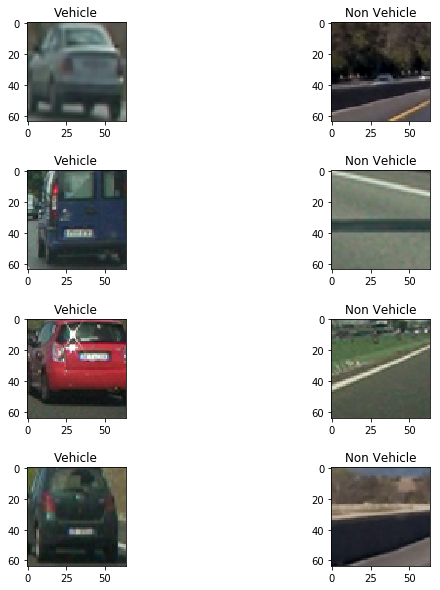

In [62]:
# Visualizing the Vehicle and Non Vehicle Images


f, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,1].set_title("Non Vehicle")
print("Shape of Vehicle Image" +  str(vehicle_images_original[vehicle].shape))
print("Shape of Non Vehicle Image" +  str(non_vehicle_images_original[non_vehicle].shape))

### Step 2- Extract Features

In [63]:
### 2.1 Experimenting with Color Spaces
### Extract Color Space

def ExtractColorHistogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel

def FindBinCenter(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

def ExtractColorFeatures(zero_channel, first_channel, second_channel):
    return np.concatenate((zero_channel[0], first_channel[0], second_channel[0]))


No of features are 384


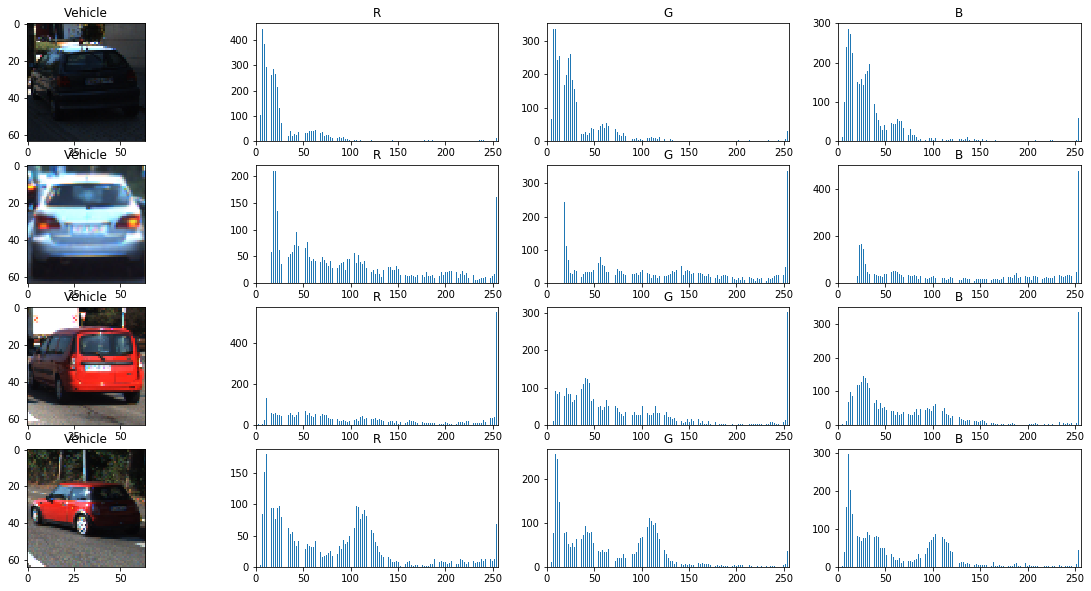

In [64]:
# Checking Color Features for Vehicles

f, axes= plt.subplots(4,4, figsize=(20,10))


for index in range(4):
    
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    r,g,b = ExtractColorHistogram(vehicle_images_original[vehicle],128)
   
    center= FindBinCenter(r)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("R")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("G")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("B")
    
features = ExtractColorFeatures(r,g,b)
print("No of features are "+ str(len(features)))
    


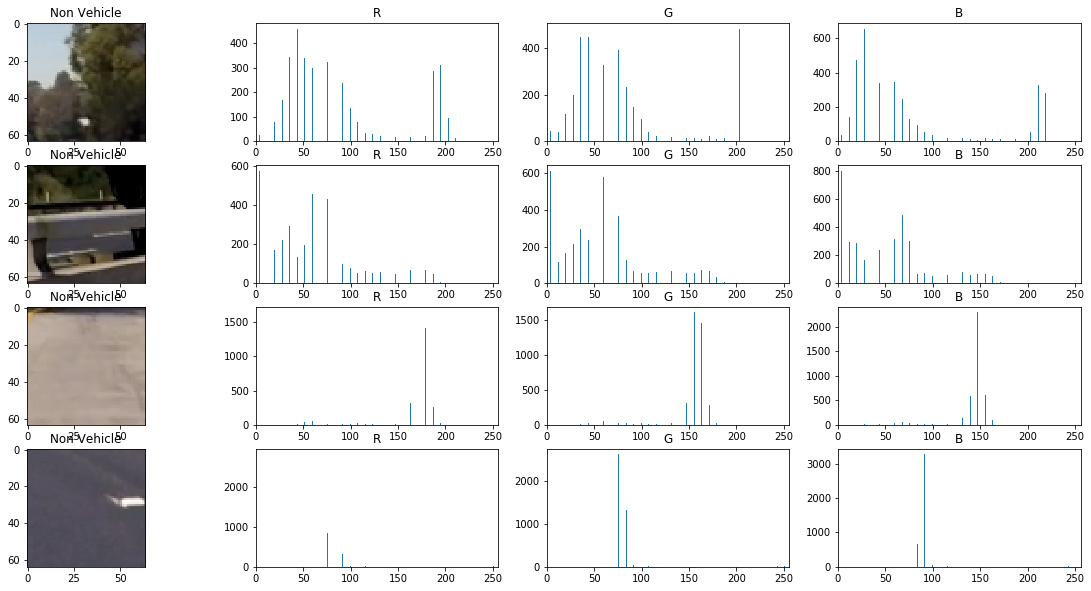

In [65]:
# Checking Color Features for Non Vehicles


f, axes= plt.subplots(4,4, figsize=(20,10))


for index in range(4):
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    r,g,b = ExtractColorHistogram(non_vehicle_images_original[non_vehicle])
    center= FindBinCenter(r)
    axes[index,0].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,0].set_title("Non Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("R")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("G")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("B")


### Step 3- Spatial Binning (optional)

In [66]:
def SpatialBinningFeatures(image,size):
    image= cv2.resize(image,size)
    return image.ravel()

In [67]:
featureList=SpatialBinningFeatures(vehicle_images_original[1],(16,16))
print(featureList.shape)

(768,)


### Step 4- HOG

In [68]:
def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

C:\Users\harveen_chadha\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


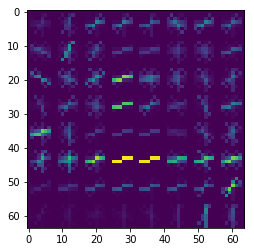

768


In [69]:
image=vehicle_images_original[1]
image=image[:,:,0]

feature1,img=GetFeaturesFromHog(image,9,2,8,visualise=True,feature_vector_flag=False)
print
plt.imshow(img)
plt.show()
print(len(featureList))

### Step 5- Generate Features Data


In [70]:
def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)

In [71]:
def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        #image=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack([local_features_1,local_features_2,local_features_3])
        featureList.append(x)
#         featureList.append(local_features_1)
#         featureList.append(local_features_2)
        #imageList.append(hogImage)
    return featureList

In [72]:
%%time

vehicleFeatures= ExtractFeatures(vehicle_images_original,9,2,16, True)
nonVehicleFeatures= ExtractFeatures(non_vehicle_images_original,9,2,16, True)


C:\Users\harveen_chadha\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Wall time: 37.1 s


In [73]:

featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures])
print("Shape of features list is ", featuresList.shape)
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of label list is ", labelList.shape)


Shape of features list is  (17341, 972)
Shape of label list is  (17341,)


### Step 6- Data Preprocessing

In [74]:
# train test split of data

from sklearn.model_selection import train_test_split

X_train,  X_test,Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)



In [75]:
#normalization and scaling

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

### Step 7- Define and Train a classifier

In [109]:
"""%%time
from sklearn.svm import SVC
classifier= SVC()
classifier.fit(X_train,Y_train)
print("Accuracy is  ", classifier.score(X_test,Y_test) )"""

Accuracy is   0.7137503603343903
Wall time: 15min 55s


In [76]:
%%time
from sklearn.svm import LinearSVC
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)
print("Accuracy is  ", classifier1.score(X_test,Y_test) )

Accuracy is   0.9896223695589507
Wall time: 903 ms


### Step 8 - Sliding Window

In [77]:
import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [78]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size= xy_window
    for i in range(0,windows_y):
        #modified_window_size = np.add(modified_window_size , 3)
        
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list
    

In [79]:
def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64))
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

C:\Users\harveen_chadha\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


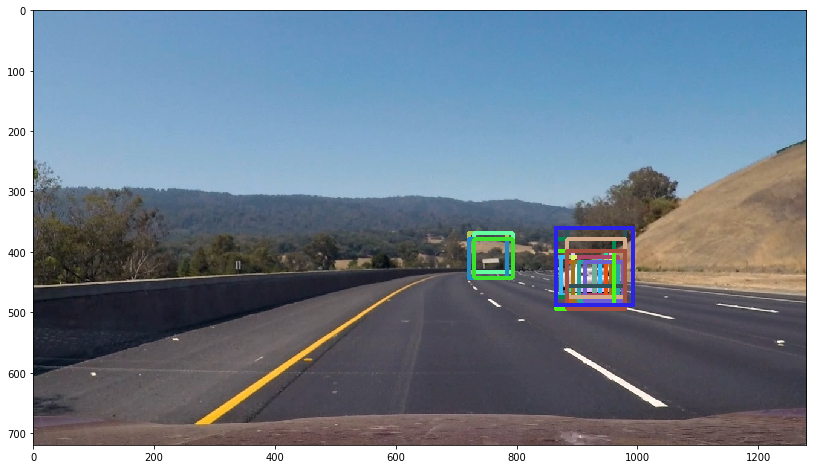

In [81]:
#testing our function

image = mpimg.imread('test3.jpg')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[360, 720], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))
windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[360, 720], 
                    xy_window=(96,96), xy_overlap=(0.2, 0.2))
windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[360, 720], 
                    xy_window=(128,128), xy_overlap=(0.25, 0.25))

windows = windows1 + windows2 +  windows3

refinedWindows=DrawCars(image,windows, True)

window_img = draw_boxes(image, refinedWindows)                    
                 
plt.figure(figsize=(16,8))
plt.imshow(window_img)
plt.show()

### Step 9 - Heatmap 

In [82]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

In [83]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [84]:
from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

1


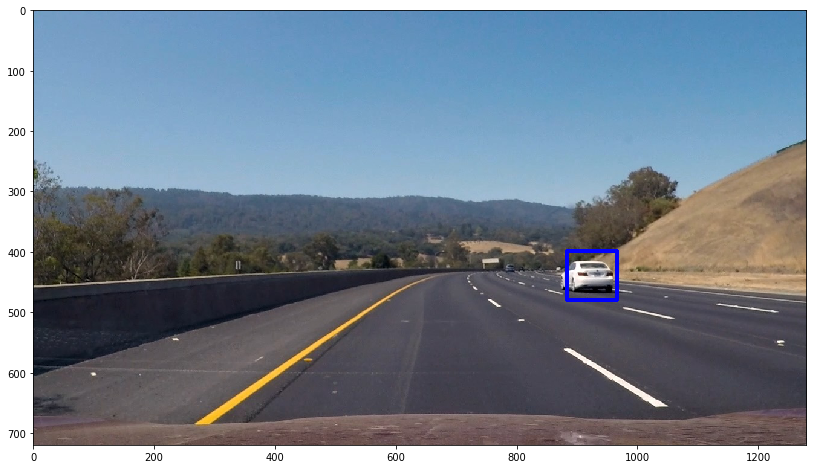

In [85]:
#testing our heat function

heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.figure(figsize=(16,8))
plt.imshow(draw_img)
plt.show()

### Step 10- Pipeline

In [88]:
orientation=9
cellsPerBlock=2
pixelsPerCell=16
xy_window=(64, 64)
xy_overlap=(0.15, 0.15)
x_start_stop=[0, image.shape[1]]
y_start_stop=[int(image.shape[0]//2), image.shape[0]]

windows_normal = slide_window(image, x_start_stop, y_start_stop, 
                    xy_window, xy_overlap)
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.30, 0.30)    
windows_1_5 = slide_window(image, x_start_stop, y_start_stop, 
                    xy_window_1_5, xy_window_1_5_overlap)
xy_window_twice_overlap=(0.50, 0.50)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, y_start_stop, 
                    xy_window_twice, xy_window_twice_overlap)
    
windows= windows_normal +  windows_1_5 + windows_twice

def Pipeline(image):
    #features,image=GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=false)
    refinedWindows=DrawCars(image,windows, True)
   
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
    heat = apply_threshold(heat,4)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

### Step 11- Testing Pipeline on Test Images

C:\Users\harveen_chadha\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Wall time: 1min 17s


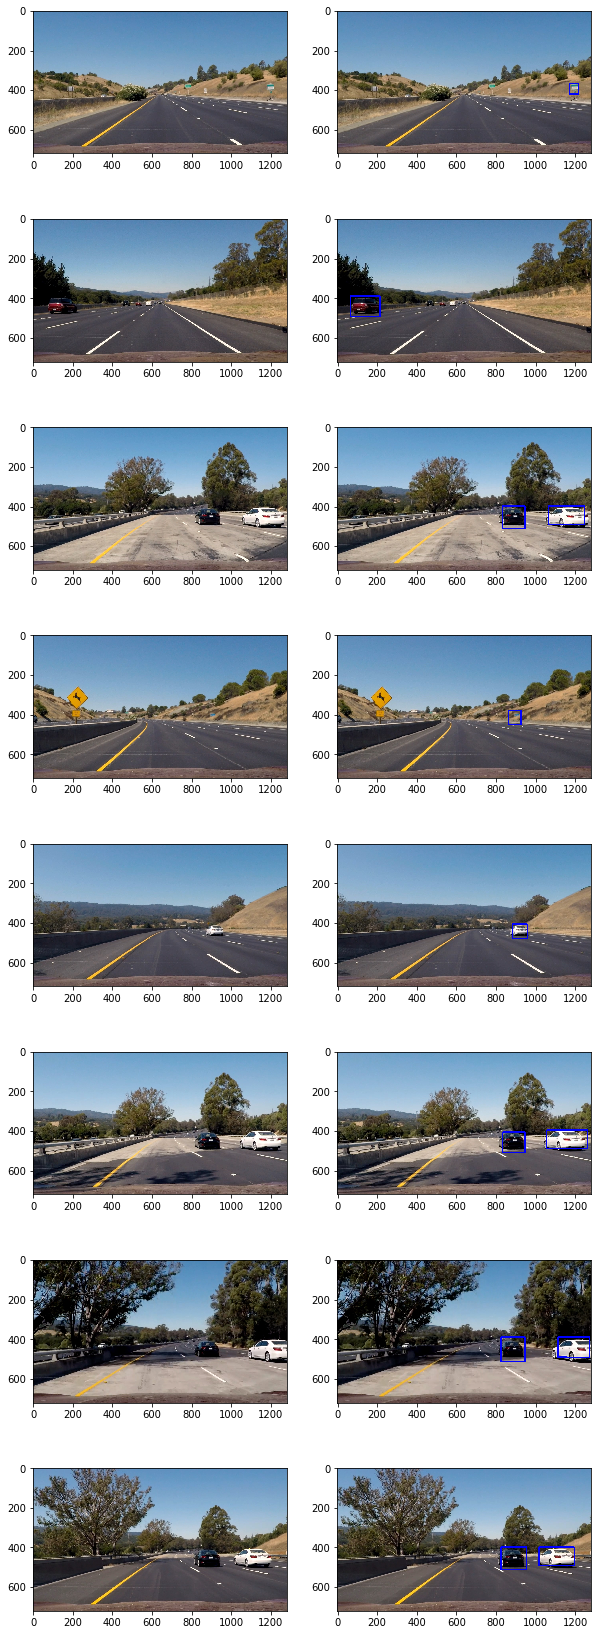

In [89]:
%%time
test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(8,2, figsize=(10,30))

for index,image in enumerate(test_images[0:8]):
    image = cv2.imread(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    finalPic = Pipeline(image)
    axes[index,0].imshow(image)
    axes[index,1].imshow(finalPic)

### Step 12- Testing Pipeline on Test Video

In [90]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(36, 37)
processed_video = video_input1.fl_image(Pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [03:46<00:09,  9.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 3min 48s
